In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch

# Set defaults

In [3]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_names = ["ET2_W42_IP7_2"]
chip_fignames = chip_names
chip_figtitles = chip_names

# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_addresses = [0x62]
ws_addresses = [None, None, None]

# i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
# i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
# #i2c_gui.__no_connect_type__ = "check"  # default behaviour

hostname = "192.168.2.7"

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# Make i2c_connection class object

In [4]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses,chip_names,[("1","1"), ("1","1"), ("1","1")])

# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [5]:
# 0 - 0 - 0 - disable / default all pixels - auto_TH_CAL - set basic peripherals - peripheral reg check -  pixel ID check
i2c_conn.config_chips('00100111')

Passed pixel check for chip: 0x62
Passed peripheral write check for chip: 0x62
Peripherals set for chip: 0x62


Calibrating and Disabling row: 100%|██████████| 16/16 [06:47<00:00, 25.44s/it]

Auto calibration and Disable Pixel operations finished for chip: 0x62


## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [6]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

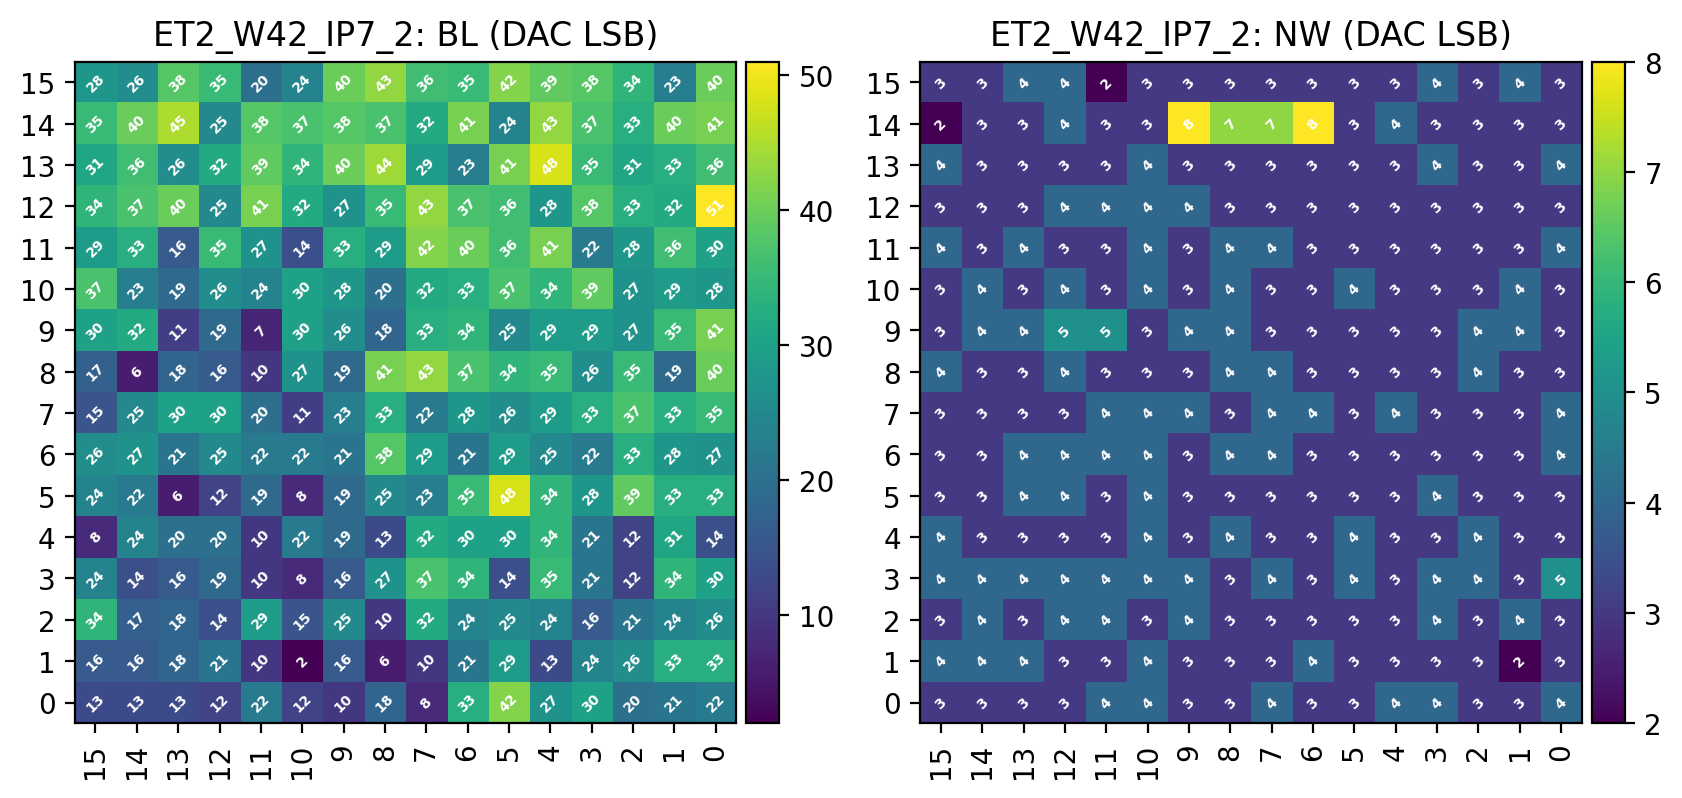

In [7]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_name in zip(chip_addresses,chip_names):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(10,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_name}: BL (DAC LSB)")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_name}: NW (DAC LSB)")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            # if(BL_map_THCal.T[x,y]==0): continue
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
    plt.show()
    # plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")

In [ ]:
# for chip_address in chip_addresses:
#     i2c_conn.onchipL1A(chip_address, comm='00')

In [ ]:
# for chip_address in chip_addresses:
#     i2c_conn.asyAlignFastcommand(chip_address)

# Define pixels of interest

In [11]:
row_list = [14, 14, 14, 14]
col_list = [6, 7, 8, 9]
# row_list = [14, 14, 15, 15]
# col_list = [6, 9, 6, 9]

scan_list = list(zip(row_list, col_list))
print(scan_list)

[(14, 6), (14, 7), (14, 8), (14, 9)]


# Enable pixels of Interest

In [9]:
i2c_conn.enable_select_pixels_in_chips(scan_list)

Enabled pixel (14,6) for chip: 0x62
Enabled pixel (14,7) for chip: 0x62
Enabled pixel (14,8) for chip: 0x62
Enabled pixel (14,9) for chip: 0x62


In [10]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(0x18, '06b'), chip)

Operating on chip 0x62 Pixel (14,6)
Operating on chip 0x62 Pixel (14,7)
Operating on chip 0x62 Pixel (14,8)
Operating on chip 0x62 Pixel (14,9)


### Disable Pixels of Interest

In [ ]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Disabling Pixel ({row},{col}) for chip {hex(chip_address)} ")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("disDataReadout", "1", chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", "0", chip)
        i2c_conn.pixel_decoded_register_write("disTrigPath", "1", chip)

# Calibrate PLL

In [ ]:
for chip_address in chip_addresses[:]:
    print(f"Calibrating PLL for chip {hex(chip_address)} ")
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    i2c_conn.peripheral_decoded_register_write("asyPLLReset", "0", chip)
    time.sleep(0.2)
    i2c_conn.peripheral_decoded_register_write("asyPLLReset", "1", chip)
    i2c_conn.peripheral_decoded_register_write("asyStartCalibration", "0", chip)
    time.sleep(0.2)
    i2c_conn.peripheral_decoded_register_write("asyStartCalibration", "1", chip)

# Calibrate FC

In [ ]:
for chip_address in chip_addresses[:]:
    print(f"Calibrating FC for chip {hex(chip_address)} ")
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    i2c_conn.peripheral_decoded_register_write("asyResetGlobalReadout", "0", chip)
    time.sleep(0.2)
    i2c_conn.peripheral_decoded_register_write("asyResetGlobalReadout", "1", chip)
    i2c_conn.peripheral_decoded_register_write("asyAlignFastcommand", "1", chip)
    time.sleep(0.2)
    i2c_conn.peripheral_decoded_register_write("asyAlignFastcommand", "0", chip)

# Did you make sure your ethernet port is on and you can ping your FPGA?

# Run One Time DAQ to Set FPGA Firmware

### No Self Trigger

In [14]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname 192.168.2.7 -t 10 -o CanBeRemoved_Board0_NoLinkCheck -v -w -s 0x0000 -p 0x000f -d 0x1800 -a 0x0011 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_NoLinkCheck'))
process.start()

IPC_queue.put('start L1A trigger bit')
while not IPC_queue.empty():
    pass
time.sleep(5)
IPC_queue.put('stop DAQ')
IPC_queue.put('stop L1A trigger bit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

In [5]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--useIPC --reset_all_till_trigger_linked --hostname 192.168.2.7 -t 10 -o CanBeRemoved_Board0_LinkCheck -v -w --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck'))
process.start()

IPC_queue.put('start L1A trigger bit')
while not IPC_queue.empty():
    pass
time.sleep(5)
IPC_queue.put('stop DAQ')
IPC_queue.put('stop L1A trigger bit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

In [ ]:
for attempt in tqdm(range(100)):
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"--useIPC --reset_all_till_trigger_linked --hostname 192.168.2.7 -t 6 -o CanBeRemoved_Board0_NoLinkCheck -v -w --clear_fifo".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_NoLinkCheck'))
    process.start()

    IPC_queue.put('start L1A trigger bit')
    while not IPC_queue.empty():
        pass
    time.sleep(2)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('stop L1A trigger bit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

### Self Trigger

#### With Qinj

In [15]:
trigger_bit_delay = int('000111'+format(484,'010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname 192.168.2.7 -t 20 -o CanBeRemoved_Board0_LinkCheck_SelfTrigger -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_SelfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

In [16]:
for attempt in tqdm(range(100)):
    for row, col in scan_list:
        i2c_conn.auto_cal_pixel(chip_name=chip_names[0], row=row, col=col, verbose=False, chip_address=chip_addresses[0], chip=None, data=None, row_indexer_handle=None, column_indexer_handle=None)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"--useIPC --reset_all_till_trigger_linked --hostname 192.168.2.7 -t 6 -o CanBeRemoved_Board0_LinkCheck_SelfTrigger -v -w".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_SelfTrigger'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit QInj BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(2)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

 25%|██▌       | 25/100 [10:24<50:13, 40.18s/it]  

#### Without QInj

In [8]:
trigger_bit_delay = int('000111'+format(484,'010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname 192.168.2.7 -t 20 -o CanBeRemoved_Board0_LinkCheck_SelfTrigger -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_SelfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

In [ ]:
for attempt in tqdm(range(100)):
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"--useIPC --reset_all_till_trigger_linked --hostname 192.168.2.7 -t 6 -o CanBeRemoved_Board0_LinkCheck_SelfTrigger -v -w".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_SelfTrigger'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(2)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

In [ ]:
for attempt in tqdm(range(100)):
    for row, col in scan_list:
        i2c_conn.auto_cal_pixel(chip_name=chip_names[0], row=row, col=col, verbose=False, chip_address=chip_addresses[0], chip=None, data=None, row_indexer_handle=None, column_indexer_handle=None)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"--useIPC --reset_all_till_trigger_linked --hostname 192.168.2.7 -t 6 -o CanBeRemoved_Board0_LinkCheck_SelfTrigger -v -w".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_SelfTrigger'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(2)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

### Find the right delay (use the middle of the three success modes, where both Qinj eges are caught)

In [ ]:
for inum in range(475, 496, 1):
    trigger_bit_delay = inum
    print(inum)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname {hostname} -t 20 -o CanBeRemoved_Board0_LinkCheck_selfTrigger_delay{inum} -v -w --s 0x0000 -p 0x000f -d {int('000111'+format(inum, '010b'), base=2)} -a 0x0011".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_selfTrigger_delay{inum}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit QInj BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(10)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

# Disconnect I2C Device

In [ ]:
del i2c_conn